              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      2586
         1.0       0.85      0.86      0.86       414

    accuracy                           0.96      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.96      0.96      0.96      3000



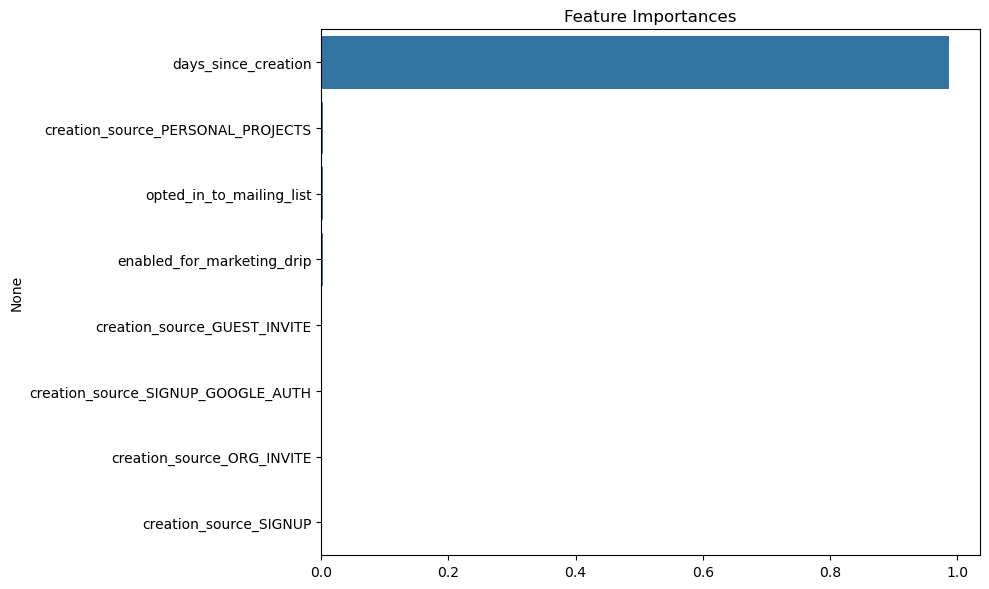

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load data
users = pd.read_csv("takehome_users.csv", encoding='latin1')
engagement = pd.read_csv("takehome_user_engagement.csv", parse_dates=['time_stamp'])

# Identify adopted users
engagement['date'] = engagement['time_stamp'].dt.date
user_dates = engagement.groupby('user_id')['date'].apply(lambda x: sorted(set(x)))

def is_adopted(dates):
    for i in range(len(dates) - 2):
        if (dates[i + 2] - dates[i]).days <= 7:
            return 1
    return 0

adopted = user_dates.apply(is_adopted).reset_index()
adopted.columns = ['object_id', 'adopted']
users = users.merge(adopted, on='object_id', how='left')
users['adopted'] = users['adopted'].fillna(0)

# Preprocessing
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s', errors='coerce')
users['days_since_creation'] = (users['last_session_creation_time'] - users['creation_time']).dt.days

categorical_cols = ['creation_source']
users = pd.get_dummies(users, columns=categorical_cols)

# Drop unused or leaked features
drop_cols = ['name', 'email', 'creation_time', 'last_session_creation_time', 'org_id', 'invited_by_user_id']
users = users.drop(columns=drop_cols)

# Prepare features
X = users.drop(columns=['object_id', 'adopted'])
y = users['adopted']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Results
print(classification_report(y_test, y_pred))

# Feature importances
feat_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances.values, y=feat_importances.index)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

### Adoption Prediction Summary

We defined **adopted users** as those who logged in on **3 separate days within a 7-day period**, as per the problem criteria.

#### Approach
- Processed engagement logs to label users as adopted or not.
- Merged with user metadata for feature engineering.
- Trained a **Random Forest Classifier** on the resulting dataset.

#### Results
- **Accuracy:** 96%
- **Precision (adopted):** 0.85 | **Recall:** 0.86 | **F1-score:** 0.86
- **Top feature:** `days_since_creation`, significantly more predictive than others.
- Features like `creation_source`, email opt-in flags, and marketing drip participation had minimal influence.

#### Conclusion
Recency of account activity is the strongest predictor of adoption. While metadata such as creation source had limited impact individually, combining them with time-based features helped achieve high accuracy. Future work could explore richer behavioral signals or interactions within organizations to improve prediction.
